## Import Library

In [91]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120

import warnings
warnings.filterwarnings('ignore')

## Load Price Data

In [92]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    raw_data = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('Remote')
    raw_data = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [93]:
ticker_data = raw_data[["Open", "Close", "Low", "High", "Volume"]]
ticker_data

,Open,Close,Low,High,Volume
Date,,,,,
2018-08-13 09:00:00,943.5,943.1,942.9,943.6,1812
2018-08-13 09:05:00,943.1,943.3,942.9,943.5,1323
2018-08-13 09:10:00,943.2,943.1,942.6,943.3,1207
2018-08-13 09:15:00,943.1,942.6,942.3,943.1,1196
2018-08-13 09:20:00,942.6,943.7,942.4,943.7,1765
...,...,...,...,...,...
2024-10-25 09:20:00,1338.4,1337.7,1337.4,1338.6,4128
2024-10-25 09:25:00,1337.7,1337.7,1337.0,1338.0,2796
2024-10-25 09:30:00,1337.7,1336.2,1335.5,1338.0,4931


In [94]:
data = ticker_data[(ticker_data.index > '2020-11-01 00:00:00') & (ticker_data.index < '2024-10-01 00:00:00')]

In [95]:
def bar9h(tick):
    tick = tick[(tick.index.hour == 9) & (tick.index.minute == 0)]
    if len(tick):
        return tick[0]


def bar14h25(tick):
    tick = tick[(tick.index.hour == 14) & (tick.index.minute == 25)]
    if len(tick):
        return tick[0]

In [96]:
data['Close_9h'] = data['Close']
data['exit_price'] = data['Close']
day_data = data.resample('D').agg({
    'Open': 'first',
    'Close': 'last',
    'High': 'max',
    'Low': 'min',
    'Close_9h': bar9h,
    'exit_price': bar14h25
})
day_data.dropna(subset=['Close'], inplace=True)
#
fibo = 0
day_data['fibo_'] = day_data['Low'].shift(1) + fibo * (day_data['High'].shift(1) - day_data['Low'].shift(1))
day_data['fibo_rate_x'] = 100 * (day_data.fibo_ - day_data.Close.shift(1)) / day_data.Close.shift(1)
day_data['fibo_rate_y'] = (day_data.fibo_ - day_data.Close_9h) / (
        day_data.High.shift(1) - day_data.Low.shift(1))
day_data['fibo_return'] = 1000 * (day_data.exit_price - day_data.fibo_) / day_data.fibo_
# risk_reward > should_long else shoutld think about short
day_data['risk_reward'] = (day_data.High - day_data.fibo_) - (day_data.fibo_ - day_data.Low)

In [97]:
len(day_data)

976

In [98]:
day_data.iloc[-1]

Open           1352.600000
Close          1357.000000
High           1357.000000
Low            1349.800000
Close_9h       1352.200000
exit_price     1355.900000
fibo_          1350.900000
fibo_rate_x      -0.339358
fibo_rate_y      -0.101562
fibo_return       3.701236
risk_reward       5.000000
Name: 2024-09-30 00:00:00, dtype: float64

### Return Distributions

In [99]:
day_data['fibo_return'].describe()

count    974.000000
mean       8.975652
std       16.810080
min      -66.586293
25%        0.436046
50%        8.139126
75%       15.777562
max      130.924721
Name: fibo_return, dtype: float64

In [100]:
day_data = day_data[(day_data['fibo_return'] > -30) & (day_data['fibo_return'] < 30)]

In [101]:
day_data['return_group'] = pd.cut(day_data['fibo_return'], 30)
s1 = day_data.groupby(['return_group'])[['fibo_return']].count()
f1 = s1[['fibo_return']].rename(columns={'fibo_return': 'count'})
day_data.drop(columns=['return_group'], inplace=True)
f1

,count
return_group,
"(-29.602, -27.564]",3
"(-27.564, -25.585]",1
"(-25.585, -23.606]",2
"(-23.606, -21.628]",3
"(-21.628, -19.649]",7
"(-19.649, -17.67]",7
"(-17.67, -15.692]",5
"(-15.692, -13.713]",6
"(-13.713, -11.735]",9


### Risk_Reward Distributions

In [102]:
day_data['risk_reward'].describe()

count    879.000000
mean      17.189534
std       21.626991
min      -57.400000
25%        3.950000
50%       16.700000
75%       30.200000
max       91.800000
Name: risk_reward, dtype: float64

In [103]:
day_data['rr_group'] = pd.cut(day_data['risk_reward'], 30)
s2 = day_data.groupby(['rr_group'])[['risk_reward']].count()
f2 = s2[['risk_reward']].rename(columns={'risk_reward': 'count'})
day_data.drop(columns=['rr_group'], inplace=True)
f2

,count
rr_group,
"(-57.549, -52.427]",3
"(-52.427, -47.453]",2
"(-47.453, -42.48]",1
"(-42.48, -37.507]",4
"(-37.507, -32.533]",1
"(-32.533, -27.56]",6
"(-27.56, -22.587]",11
"(-22.587, -17.613]",17
"(-17.613, -12.64]",23


### Percent Distributions

In [104]:
day_data['fibo_rate_x'].describe()

count    879.000000
mean      -0.705231
std        0.640433
min       -3.781818
25%       -0.987806
50%       -0.529101
75%       -0.246158
max        0.000000
Name: fibo_rate_x, dtype: float64

In [105]:
day_data['fibo_rate_y'].describe()

count    877.000000
mean      -0.556708
std        0.538313
min       -3.020000
25%       -0.918644
50%       -0.601770
75%       -0.196203
max        3.104478
Name: fibo_rate_y, dtype: float64

In [106]:
day_data['fibo_rate_x_group'] = pd.qcut(day_data.fibo_rate_x, 20, duplicates='drop')
day_data['fibo_rate_y_group'] = pd.qcut(day_data.fibo_rate_y, 20, duplicates='drop')

## Reward - Risk Analysis

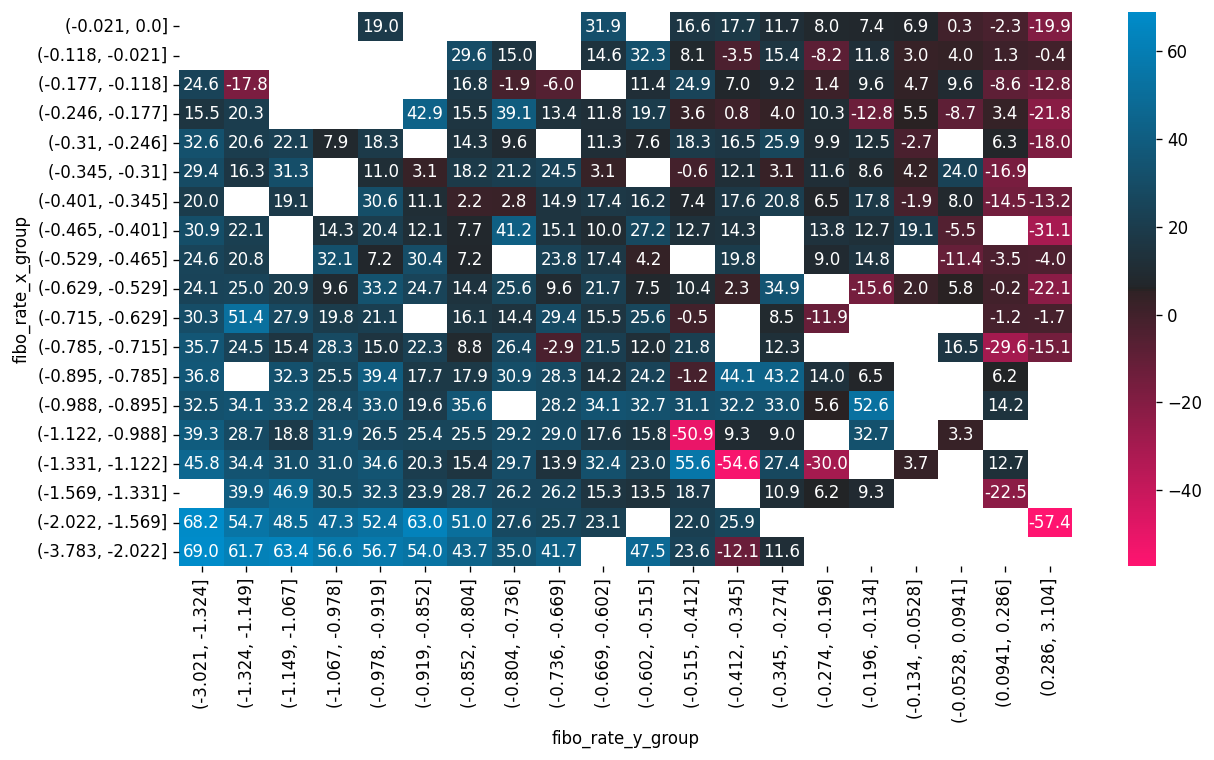

In [107]:
risk_reward_group = day_data.groupby(['fibo_rate_x_group', 'fibo_rate_y_group'])[['risk_reward']]
risk_reward_mean = risk_reward_group.mean().reset_index()
risk_reward_pivot = risk_reward_mean.pivot(index='fibo_rate_x_group', columns='fibo_rate_y_group', values='risk_reward').sort_index(ascending=False)
sns.heatmap(
    risk_reward_pivot,
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
    annot=True, fmt=".1f");

## Mean return Analytics

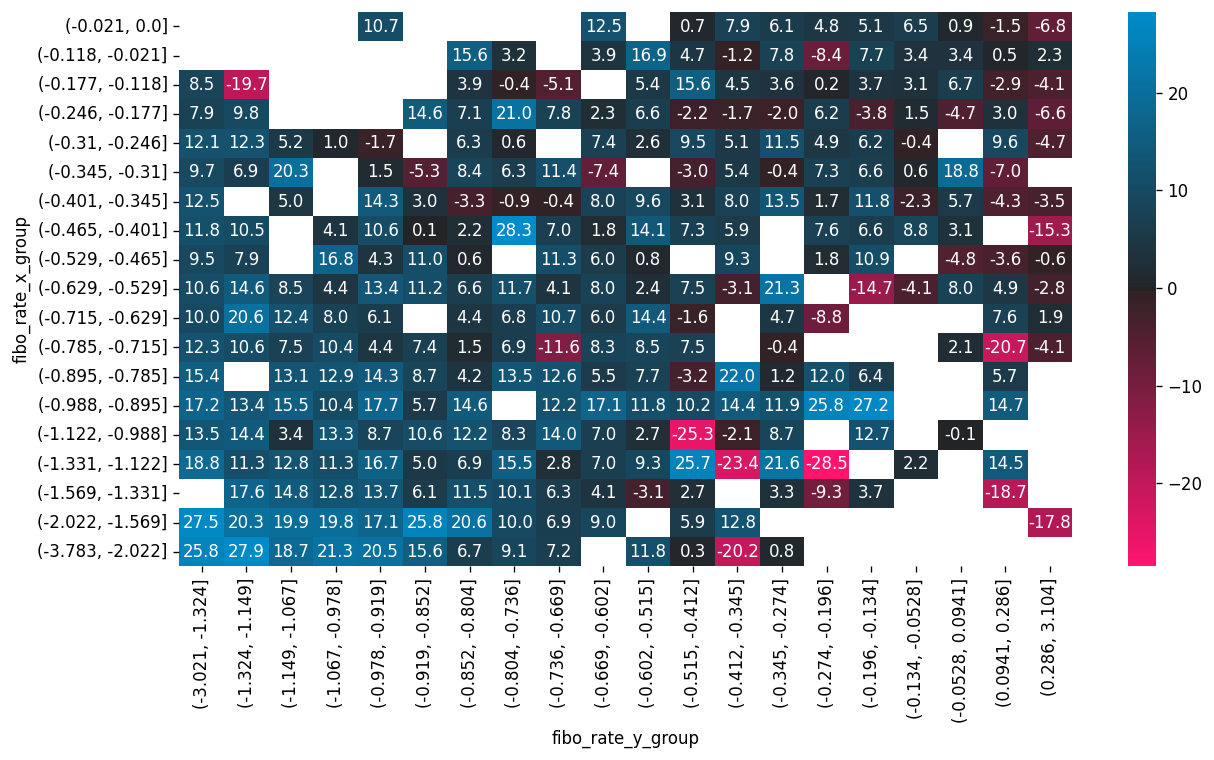

In [108]:
grpd = day_data.groupby(['fibo_rate_x_group', 'fibo_rate_y_group'])[['fibo_return']]
irs = grpd.mean().reset_index()
pivot_df = irs.pivot(index='fibo_rate_x_group', columns='fibo_rate_y_group', values='fibo_return').sort_index(ascending=False)
sns.heatmap(
    pivot_df,
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
    annot=True, fmt=".1f");

In [109]:
import pickle
fibo_x = int(fibo * 1000) if (fibo != 0.5 and fibo != 1) else fibo

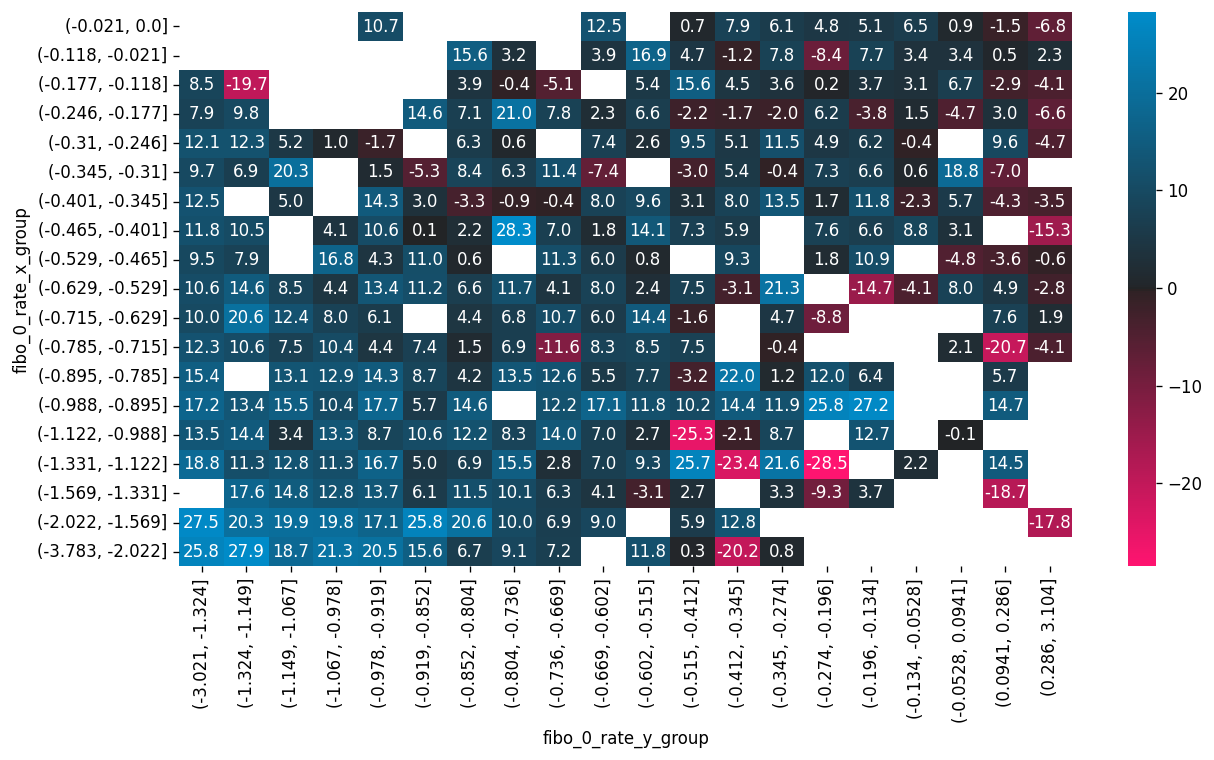

In [110]:
fibo_mean_return_db_file = str(algo_dir) + '/VN30ps/fibonacci/fibo_' + str(fibo_x) + '_mean_return_db.pkl'
is_file = os.path.isfile(fibo_mean_return_db_file)
if is_file:
    with open(fibo_mean_return_db_file, 'rb') as f:
        stored_pivot_df = pickle.load(f)
        sns.heatmap(
        stored_pivot_df,
        cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
        annot=True, fmt=".1f");
else:
    print(fibo_db_file)
    print('DB file not found.')

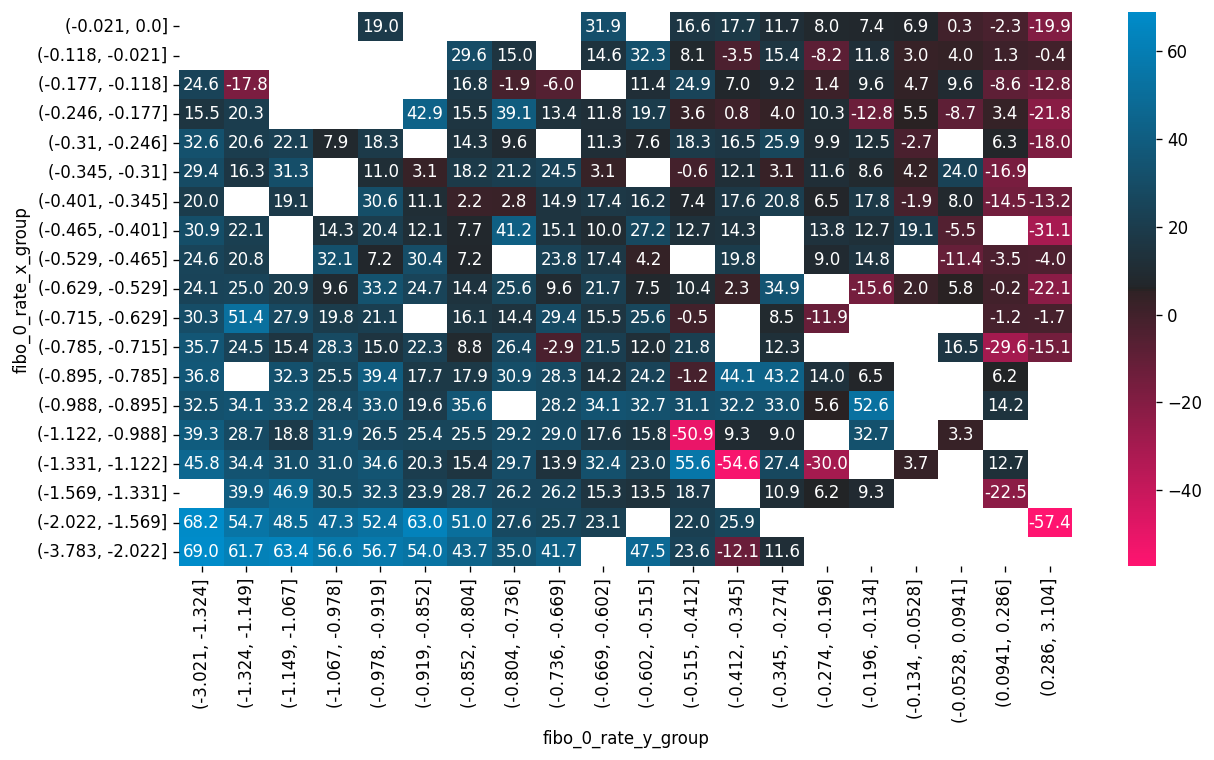

In [111]:
fibo_risk_reward_db_file = str(algo_dir) + '/VN30ps/fibonacci/fibo_' + str(fibo_x) + '_risk_reward_db.pkl'
is_file = os.path.isfile(fibo_risk_reward_db_file)
if is_file:
    with open(fibo_risk_reward_db_file, 'rb') as f:
        stored_pivot_df = pickle.load(f)
        sns.heatmap(
        stored_pivot_df,
        cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
        annot=True, fmt=".1f");
else:
    print(fibo_db_file)
    print('DB file not found.')

In [112]:
fibo_db_file

'/home/zuongthao/PycharmProjects/algo-stock/VN30ps/fibonacci/fibo_1_mean_return_db.pkl'

In [113]:
def find_mean_return(fibo_rate_x, fibo_rate_y, pivot_df):
    found_i = None
    for i in pivot_df.index:
        if i.left < fibo_rate_x <= i.right:
            found_i = i
            break
    found_c = None
    for c in pivot_df.columns:
        if c.left < fibo_rate_y <= c.right:
            found_c = c
            break
    found = pivot_df.loc[pivot_df.index == found_i, found_c]
    if len(found):
        val = found.values[0]
        return val